In [1]:
import pickle

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np

from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

In [2]:
data = pickle.load(open("/home/mattia/qubic/qubic/scripts/MapMaking/src/FMM/test_master/maps/test_None.pkl", "rb"))

In [3]:
data.keys()

dict_keys(['maps_in', 'maps', 'maps_noise', 'tod', 'nus', 'coverage', 'convergence', 'center', 'parameters', 'fwhm_in', 'fwhm_out', 'fwhm_rec', 'seenpix', 'duration', 'qubic_dict'])

In [4]:
fwhm_in = data["fwhm_in"]
fwhm_out = data["fwhm_out"]
fwhm_rec = data["fwhm_rec"]

nus = data["nus"]
Nrec = nus.shape[0] - 7

maps_input = data["maps_in"]
maps_rec = data["maps"][:Nrec] #np.array([C[i](data["components_i"][i]) for i in range(len(C))])
maps_res = maps_input - maps_rec
center = data["center"]
seenpix = data["seenpix"]
convergence = data["convergence"]

In [5]:
print(Nrec)
print(nus.shape)
print(maps_input.shape)

8
(15,)
(8, 196608, 3)


In [6]:
print("FWHM in: ", fwhm_in)
print("mean fwhm in: ", np.mean(fwhm_in))
print("FWHM out: ", fwhm_out)
print("FWHM rec: ", fwhm_rec)

FWHM in:  [0. 0. 0. 0. 0. 0. 0. 0.]
mean fwhm in:  0.0
FWHM out:  [0. 0. 0. 0. 0. 0. 0. 0.]
FWHM rec:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


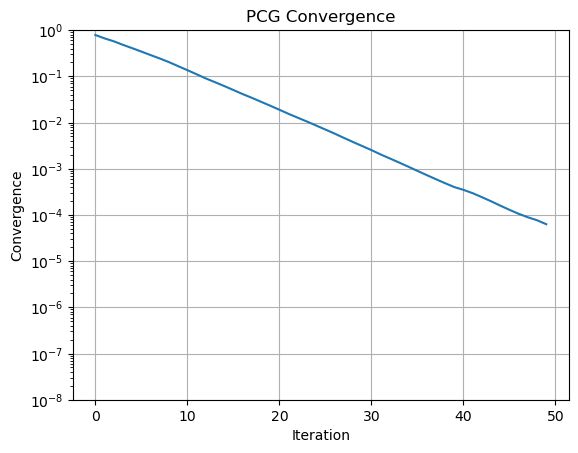

In [7]:
plt.plot(convergence)
plt.xlabel("Iteration")
plt.ylabel("Convergence")
plt.title("PCG Convergence")
plt.yscale("log")
plt.ylim(1e-8, 1e0)
plt.grid()
plt.show()

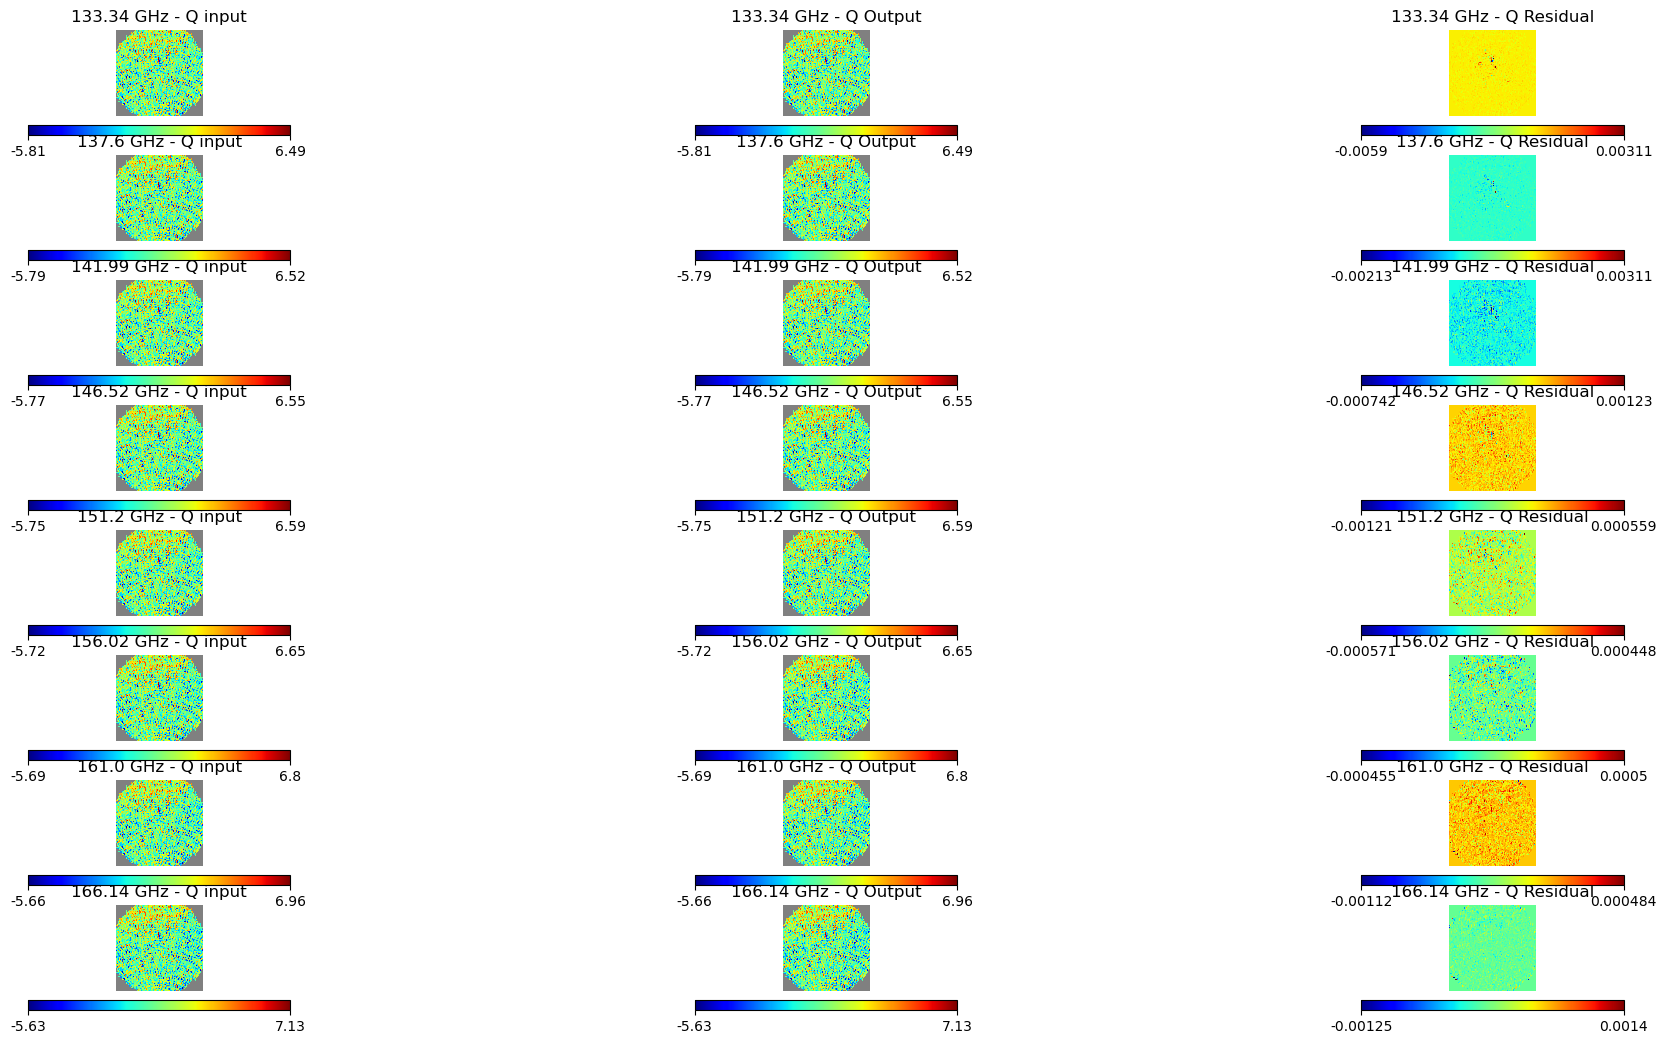

In [8]:
STOKES = ["I", "Q", "U"]

# maps_input[:, ~seenpix, :] = hp.UNSEEN
# maps_rec[:, ~seenpix, :] = hp.UNSEEN
# maps_res[:, ~seenpix, :] = hp.UNSEEN

istk = 1
n = 2
# sigma_input = np.std(maps_input[:, seenpix, istk], axis=0)
# sigma_rec = np.std(maps_rec[:, seenpix, istk], axis=0)
# sigma_res = np.std(maps_rec[:, seenpix, istk] - maps_input[:, seenpix, istk], axis=0)

reso = 12

k = 0

plt.figure(figsize=(20, 10))
for inu in range(Nrec):
    hp.gnomview((maps_input[inu, :, istk]), rot=center,
                        reso=reso,
                        notext=True,
                        title=f"{nus[inu].round(2)} GHz - {STOKES[istk]} input",  
                        cmap="jet",
                        # min = - n * sigma_input[inu],
                        # max = n * sigma_input[inu],
                        sub=(Nrec, 3, k + 1))
    
    hp.gnomview((maps_rec[inu, :, istk]), rot=center,
                        reso=reso,
                        notext=True,
                        title=f"{nus[inu].round(2)} GHz - {STOKES[istk]} Output",
                        cmap="jet",
                        # min = - n * sigma_rec[inu],
                        # max = n * sigma_rec[inu],
                        sub=(Nrec, 3, k + 2))
    
    hp.gnomview(maps_res[inu, :, istk], rot=center,
                        reso=reso,
                        notext=True,
                        title=f"{nus[inu].round(2)} GHz - {STOKES[istk]} Residual",
                        cmap="jet",
                        # min = - n * sigma_res[inu],
                        # max = n * sigma_res[inu],
                        sub=(Nrec, 3, k + 3))
    k += 3

In [9]:
stop

NameError: name 'stop' is not defined

In [11]:
icomp = 0

test_in = data["components"][icomp].copy()
test_out = data["components_i"][icomp].copy()

test_in[~seenpix, :] = 0
test_out[~seenpix, :] = 0

KeyError: 'components'

In [12]:
def chi2_fwhm(fwhm):
    if fwhm < 0 or fwhm > 0.1:
        return np.inf
    else:
        C = HealpixConvolutionGaussianOperator(fwhm)
        input_maps = C(test_in)
            
        return np.sum((test_out - input_maps) ** 2) / np.sum(input_maps ** 2)

In [13]:
list_chi2 = []

fwhm = np.logspace(np.log10(0.0005), np.log10(0.05), num=80)
for i in fwhm:
    list_chi2.append(chi2_fwhm(i))

list_chi2 = np.array(list_chi2)

NameError: name 'test_in' is not defined

ValueError: x and y must have same first dimension, but have shapes (80,) and (0,)

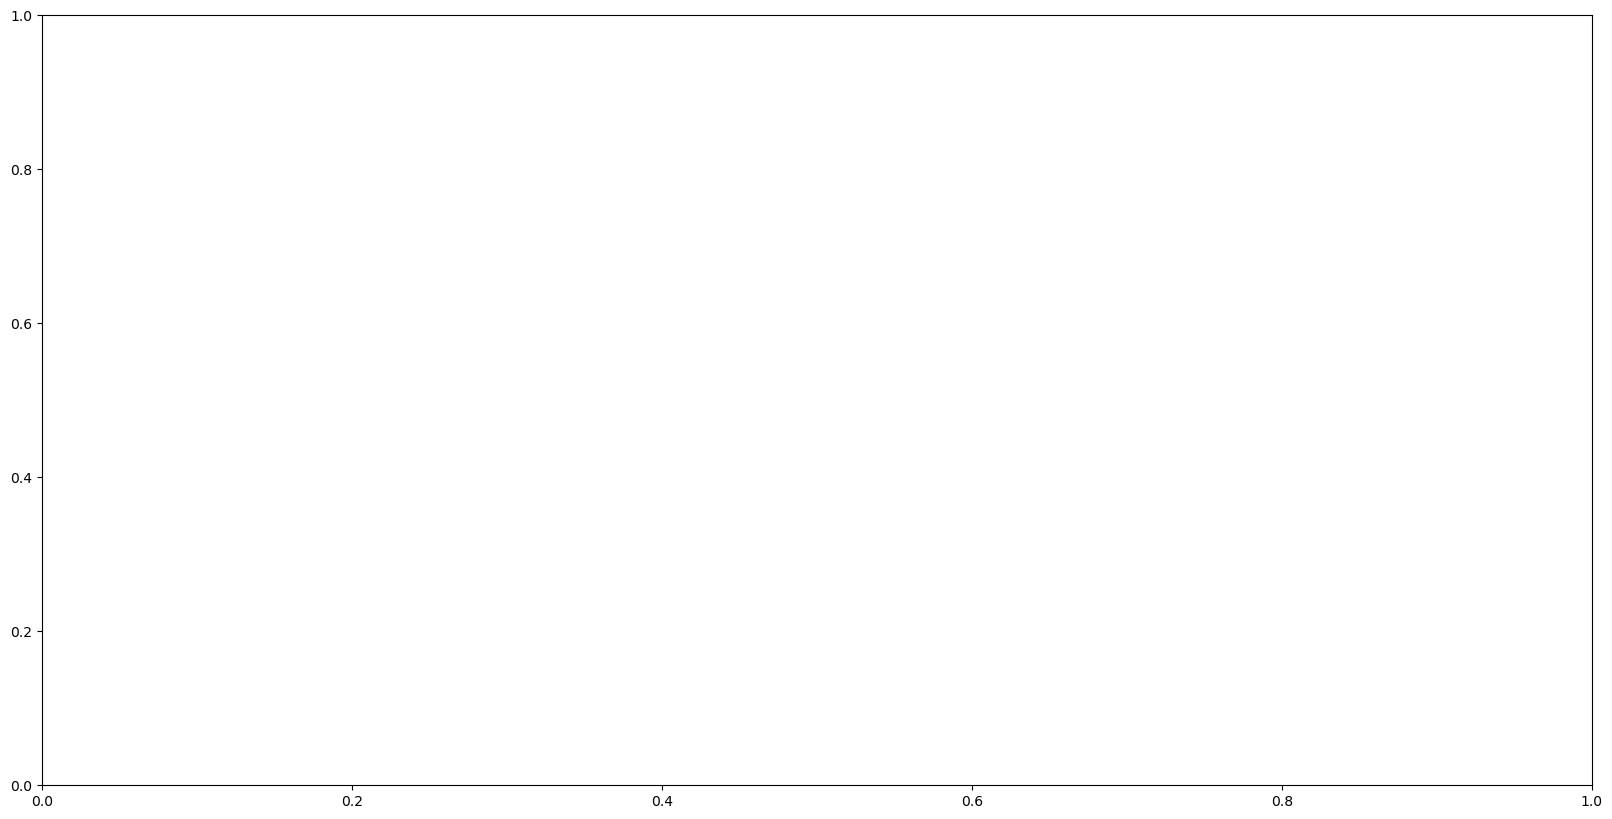

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(fwhm, list_chi2)
plt.vlines(fwhm[np.where(list_chi2 == np.min(list_chi2))[0][0]], 0, 2, color="red", linestyle="--", label=f"Best fit : {fwhm[np.where(list_chi2 == np.min(list_chi2))[0][0]].round(4)}")
plt.vlines(fwhm_rec[icomp], 0, 2, color="green", linestyle="--", label=f"FWHM rec : {fwhm_rec[icomp].round(4)}")
plt.title("Chi2 as a function of fwhm")
plt.xlabel("FWHM")
plt.ylabel("Chi2")
plt.grid()
plt.legend()
plt.show()

DB

[BlockColumnOperator([
    CompositionOperator([
        ReshapeOperator((2,992,1000), 1984000, None),
        BlockDiagonalOperator([
            AdditionOperator([
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00032073412942351155, ..., 0.00032073412942351155], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.3369798843648294e-20, ..., 1.637328135911787e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.0003088551824867947, ..., 0.0003088551824867947], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.523479673700379e-20, ..., 1.8657245059632232e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00029098003796839035, ..., 0.00029098003796839035], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.723854730428402e-20, ..., 2.111113177814166e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00026742247781682567, ..., 0.00026742247781682567], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.9354680197333515e-20, ..., 2.3702647152185153e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))])]),
            AdditionOperator([
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.0003256755373312783, ..., 0.0003256755373312783], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[5.220424377585131e-20, ..., 6.393176004200445e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00031816117605010404, ..., 0.00031816117605010404], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[5.624800896322368e-20, ..., 6.888394413522351e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00030468071051658723, ..., 0.00030468071051658723], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[5.984199008693123e-20, ..., 7.328530161456797e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00028524522232625555, ..., 0.00028524522232625555], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[6.2791104131497e-20, ..., 7.689692468956596e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))])])])]),
    CompositionOperator([
        ReshapeOperator((2,589824), 1179648, None),
        BlockDiagonalOperator([
            ReshapeOperator((196608,3), 589824, None),
            ReshapeOperator((196608,3), 589824, None)])])]), UnpackOperator(array([[[False, ..., False]]], dtype=bool), None, shapein=39636, shapeout=(2,196608,3)), ReshapeOperator((2,6606,3), 39636, None)]


UWB

[BlockColumnOperator([
    CompositionOperator([
        ReshapeOperator((992,1000), 992000, None),
        BlockRowOperator([
            AdditionOperator([
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00032073412942351155, ..., 0.00032073412942351155], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.3369798843648294e-20, ..., 1.637328135911787e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.0003088551824867947, ..., 0.0003088551824867947], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.523479673700379e-20, ..., 1.8657245059632232e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00029098003796839035, ..., 0.00029098003796839035], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.723854730428402e-20, ..., 2.111113177814166e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00026742247781682567, ..., 0.00026742247781682567], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[1.9354680197333515e-20, ..., 2.3702647152185153e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))])]),
            AdditionOperator([
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.0003256755373312783, ..., 0.0003256755373312783], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[5.220424377585131e-20, ..., 6.393176004200445e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00031816117605010404, ..., 0.00031816117605010404], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[5.624800896322368e-20, ..., 6.888394413522351e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00030468071051658723, ..., 0.00030468071051658723], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[5.984199008693123e-20, ..., 7.328530161456797e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))]),
                CompositionOperator([
                    ConvolutionTruncatedExponentialOperator(0.01, None, shapein=(992,1000), shapeout=(992,1000)),
                    DiagonalOperator(array([0.00028524522232625555, ..., 0.00028524522232625555], dtype=float64), broadcast='rightward', None),
                    ReshapeOperator((992,1000,1), (992,1000), None),
                    DenseBlockDiagonalOperator(array([[[[6.2791104131497e-20, ..., 7.689692468956596e-36]]]], dtype=float64), naxesin=1, naxesout=1, None, shapein=(992,1000,3), shapeout=(992,1000,1)),
                    ProjectionOperator(None, None, shapein=(196608,3), shapeout=(992,1000,3))])])])]),
    CompositionOperator([
        ReshapeOperator((2,589824), 1179648, None),
        BlockDiagonalOperator([
            ReshapeOperator((196608,3), 589824, None),
            ReshapeOperator((196608,3), 589824, None)])])]), UnpackOperator(array([[[False, ..., False]]], dtype=bool), None, shapein=39636, shapeout=(2,196608,3)), ReshapeOperator((2,6606,3), 39636, None)]
